# Spatial Transcriptomics Visium 

## 1. Dataset Download

The Dataset is publicly available under GEO Number: GSE211895

This is how to downloaded it: 

In [ ]:
!wget -c -O RawFiles.zip "https://smi-public.objects.liquidweb.services/6k_release/RawFiles.zip"
# !!!Careful!!! Datset is big --> 650 GB!, Later on i will just use parts of it to demonstrate analysis)

## 2. Loading Data

### Import Libraries
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Unfortunately the dataset we downloaded need first to be prepared for the analysis.

1.) Generate manually a data structure that looks like this for one sample: 

```SampleName/
├── filtered_feature_bc_matrix/  # Main gene expression matrix
├── raw_feature_bc_matrix/       # Unfiltered counts
├── spatial/                     # Spatial imaging data
│   ├── tissue_positions_list.csv  # Spot coordinates
│   ├── scalefactors_json.json     # Scale factors for images
│   ├── tissue_lowres_image.png    # Low-res histology image
│   └── tissue_hires_image.png    # High-res histology image
```
**Remove for this also the Prefix** from each sample of this dataset, so that the filename is the same as shown in the tree above (see alternative way to load the file below without removing the name but I did already, so this is the manual way) 

3.) The lowres_image.png is not provided. I will show how to generate it and how to adopt the scalefactors file.

In [9]:
from PIL import Image

# Load high-resolution image
img = Image.open("data/GSME6505118_RatColon_FF_A_e4/spatial/tissue_hires_image.png")

# Downscale (adjust factor to match typical Visium ratios)
scale_factor = 0.1  # 10x smaller
new_size = (int(img.width * scale_factor), int(img.height * scale_factor))

# Resize
img_lowres = img.resize(new_size, Image.LANCZOS)

# Save as lowres image
img_lowres.save("data/GSME6505118_RatColon_FF_A_e4/spatial/tissue_lowres_image.png")


In [10]:
# Edit the JSON file
import json
with open("data/GSME6505118_RatColon_FF_A_e4/spatial/scalefactors_json.json") as f:
    scales = json.load(f)
scales["tissue_lowres_scalef"] = scales["tissue_hires_scalef"] * scale_factor
with open("data/GSME6505118_RatColon_FF_A_e4/spatial/scalefactors_json.json", "w") as f:
    json.dump(scales, f, indent=4)

In [37]:
# If you did not change the name load it like this: 
#adata = sq.read.visium('data/GSME6505118_RatColon_FF_A_e4/', counts_file = 'your_file_name_filtered_feature_bc_matrix.h5')


/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [47]:
# Otherwise load it like this:
adata = sq.read.visium('data/GSME6505118_RatColon_FF_A_e4/')
adata.var_names_make_unique()


/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [48]:
adata # around 1428 spots in the image with 25399 genes

AnnData object with n_obs × n_vars = 1428 × 25399
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [49]:
adata.uns['spatial']['FF_RatColon_r2_t1_s1_without-coverslip_A']['images']['hires'].shape

(2000, 1862, 3)

In [50]:
# Contains coordinate positions, should corresponds to the number of spots/positions
adata.obsm['spatial'].shape

(1428, 2)

In [51]:
adata.obs['spot'] = 'a'

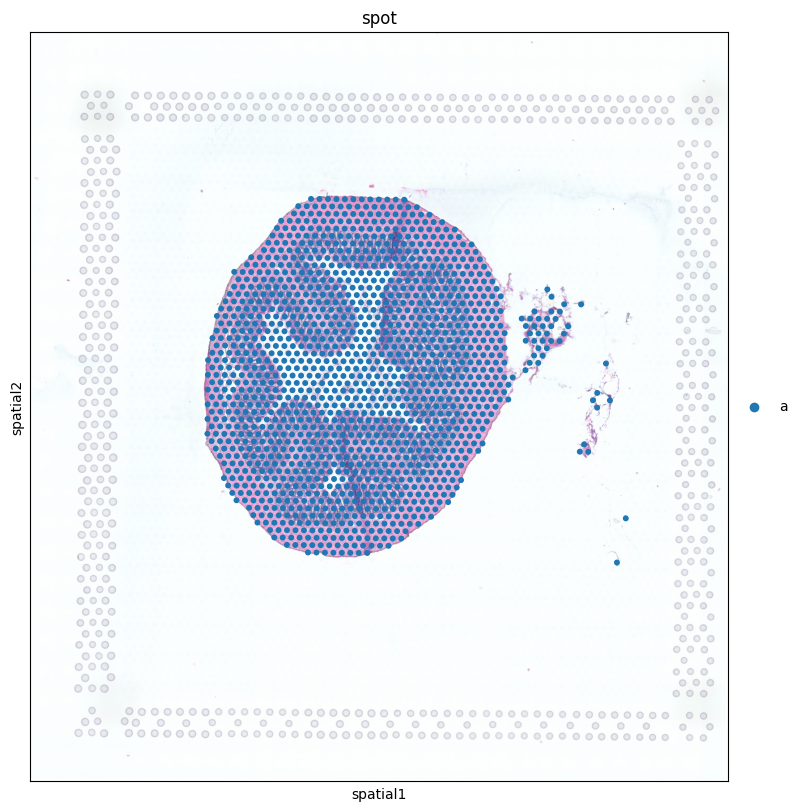

In [52]:
sq.pl.spatial_scatter(adata, color='spot', size=1)

## 3. Preprocessing and QC

I don't know the data, so let's see what suprise awaits us here.

In [56]:
# Annotate mitochondrial genes in adata
adata.var['mt'] = [gene.startswith('Mt-') for gene in adata.var_names]

In [60]:
# Calculate qc_metrics
sc.pp.calculate_qc_metrics(adata, inplace=True,qc_vars=['mt'])

In [61]:
# Check shortly if we really got mitochondrial values (choose the correct writing for the correct species, so pct_counts_mt should have values)
adata.obs

,in_tissue,array_row,array_col,spot,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCGGGTAGGTACC-1,1,42,28,a,5096,8.536407,21597.0,9.980356,22.174376,31.499745,41.209427,55.169699,601.0,6.400258,2.782794
AAACCGTTCGTCCAGG-1,1,52,42,a,4795,8.475538,19144.0,9.859797,21.165901,31.372754,41.506477,55.343711,633.0,6.452049,3.306519
AAACCTCATGAAGTTG-1,1,37,19,a,3387,8.127995,11459.0,9.346618,29.112488,38.415219,47.962300,61.855310,613.0,6.419995,5.349507
AAACGAGACGGTTGAT-1,1,35,79,a,3714,8.220134,10961.0,9.302190,20.655050,29.176170,39.211751,55.104461,456.0,6.124683,4.160204
AAACTGCTGGCTCCAA-1,1,45,67,a,4360,8.380457,15037.0,9.618336,22.052271,30.784066,40.406996,54.625258,350.0,5.860786,2.327592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTTTCCCGAAAG-1,1,51,59,a,4554,8.423981,16552.0,9.714323,21.562349,30.225955,39.705172,54.307637,439.0,6.086775,2.652247
TTGTTAGCAAATTCGA-1,1,22,42,a,3657,8.204672,12313.0,9.418492,27.921709,36.619833,46.300658,60.204662,806.0,6.693324,6.545928
TTGTTCAGTGTGCTAC-1,1,24,64,a,3695,8.215006,10961.0,9.302190,22.543564,31.101177,40.589362,55.086215,301.0,5.710427,2.746100
TTGTTGTGTGTCAAGA-1,1,31,77,a,4621,8.438583,18158.0,9.806922,24.253772,32.514594,42.273378,56.448948,699.0,6.551080,3.849543


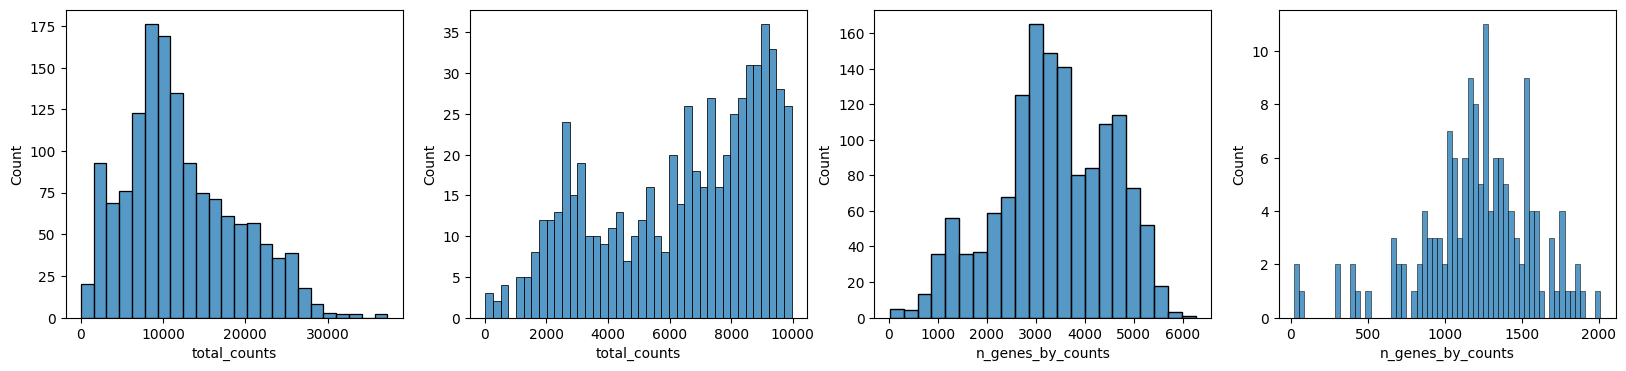

In [70]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
sns.histplot(adata.obs['total_counts'], kde=False, ax = axs[0])
sns.histplot(adata.obs['total_counts'][adata.obs['total_counts'] < 10000], bins=40, kde=False, ax = axs[1])
sns.histplot(adata.obs['n_genes_by_counts'], kde=False, ax = axs[2])
sns.histplot(adata.obs['n_genes_by_counts'][adata.obs['total_counts'] < 4000], bins=60, kde=False, ax = axs[3])

plt.show()

Data is okayis but not best